# FOLIUM VECTORS

## Folium Vector Attempt 1

In [23]:
##THIS IS PARTIAL CODE, DO NOT RUN
import numpy as np
#from netCDF4 import Dataset
import netCDF4
from oceans import wrap_lon180


nc = Dataset('./data/mdt_cnes_cls2009_global_v1.1.nc')

u = nc['Grid_0002'][:]
v = nc['Grid_0003'][:]
lon = nc['NbLongitudes'][:]
lat = nc['NbLatitudes'][:]
err = nc['Grid_0004'][:]

lon = wrap_lon180(lon)
lon, lat = np.meshgrid(lon, lat)

OSError: No such file or directory

In [22]:
mask_x = np.logical_and(lon > -40, lon < -34)
mask_y = np.logical_and(lat > -16, lat < -12)
mask = np.logical_and(mask_x, mask_y)

NameError: name 'lon' is not defined

In [ ]:
x = lon[mask]
y = lat[mask]
U = u.T[mask].filled(fill_value=0)
V = v.T[mask].filled(fill_value=0)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

kw = dict(color='black', alpha=0.8, scale=1)
q = ax.quiver(x, y, U, V, **kw)

In [ ]:
import mplleaflet

gj = mplleaflet.fig_to_geojson(fig=fig)

In [ ]:
import folium

feature_group0 = folium.FeatureGroup(name='quiver')

mapa = folium.Map(location=[y.mean(), x.mean()], tiles="Cartodb Positron",
                  zoom_start=7)

for feature in gj['features']:
    if feature['geometry']['type'] == 'Point':
        lon, lat = feature['geometry']['coordinates']
        div = feature['properties']['html']

        icon_anchor = (feature['properties']['anchor_x'],
                       feature['properties']['anchor_y'])

        icon = folium.features.DivIcon(html=div,
                                       icon_anchor=icon_anchor)
        marker = folium.Marker([lat, lon], icon=icon)
        feature_group0.add_children(marker)
    else:
        msg = "Unexpected geometry {}".format
        raise ValueError(msg(feature['geometry']))

url = 'http://gmrt.marine-geo.org/cgi-bin/mapserv?map=/public/mgg/web/gmrt.marine-geo.org/htdocs/services/map/wms_merc.map'
wms = folium.features.WmsTileLayer(url,
                                   name='GMRT',
                                   format='image/png',
                                   layers='topo',
                                   transparent=True)
feature_group1 = folium.FeatureGroup(name='Topo')
feature_group1.add_children(wms)

In [ ]:
mapa.add_children(feature_group0)
mapa.add_children(feature_group1)
mapa.add_children(folium.map.LayerControl())
mapa

## Folium Vector Attempt 2

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

In [69]:
tidx = -1       # just get the final frame, for now.
scale = .02 ## This variable can be played with to determine arrow size
isub = 3
url = 'http://geoport-dev.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd'
#url = 'http://geoport.whoi.edu/thredds/dodsC/examples/bora_feb.nc'

In [70]:
def shrink(a,b):
    """Return array shrunk to fit a specified shape by triming or averaging.
    
    a = shrink(array, shape)
    
    array is an numpy ndarray, and shape is a tuple (e.g., from
    array.shape). a is the input array shrunk such that its maximum
    dimensions are given by shape. If shape has more dimensions than
    array, the last dimensions of shape are fit.
    
    as, bs = shrink(a, b)
    
    If the second argument is also an array, both a and b are shrunk to
    the dimensions of each other. The input arrays must have the same
    number of dimensions, and the resulting arrays will have the same
    shape.
    Example
    -------
    
    >>> shrink(rand(10, 10), (5, 9, 18)).shape
    (9, 10)
    >>> map(shape, shrink(rand(10, 10, 10), rand(5, 9, 18)))        
    [(5, 9, 10), (5, 9, 10)]   
       
    """

    if isinstance(b, np.ndarray):
        if not len(a.shape) == len(b.shape):
            raise Exception(
                  'input arrays must have the same number of dimensions')
        a = shrink(a,b.shape)
        b = shrink(b,a.shape)
        return (a, b)

    if isinstance(b, int):
        b = (b,)

    if len(a.shape) == 1:                # 1D array is a special case
        dim = b[-1]
        while a.shape[0] > dim:          # only shrink a
            if (dim - a.shape[0]) >= 2:  # trim off edges evenly
                a = a[1:-1]
            else:                        # or average adjacent cells
                a = 0.5*(a[1:] + a[:-1])
    else:
        for dim_idx in range(-(len(a.shape)),0):
            dim = b[dim_idx]
            a = a.swapaxes(0,dim_idx)        # put working dim first
            while a.shape[0] > dim:          # only shrink a
                if (a.shape[0] - dim) >= 2:  # trim off edges evenly
                    a = a[1:-1,:]
                if (a.shape[0] - dim) == 1:  # or average adjacent cells
                    a = 0.5*(a[1:,:] + a[:-1,:])
            a = a.swapaxes(0,dim_idx)        # swap working dim back

    return a

In [71]:
def rot2d(x, y, ang):
    '''rotate vectors by geometric angle'''
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)
    return xr, yr

In [76]:
nc = netCDF4.Dataset(url)
mask = nc.variables['mask_rho'][:]
lon_rho = nc.variables['lon_rho'][:]
lat_rho = nc.variables['lat_rho'][:]
anglev = nc.variables['angle'][:]

u = nc.variables['u'][tidx, -1, :, :]
v = nc.variables['v'][tidx, -1, :, :]

u = shrink(u, mask[1:-1, 1:-1].shape)
v = shrink(v, mask[1:-1, 1:-1].shape)

u, v = rot2d(u, v, anglev[1:-1, 1:-1])

In [77]:
lon_c = lon_rho[1:-1, 1:-1]
lat_c = lat_rho[1:-1, 1:-1]

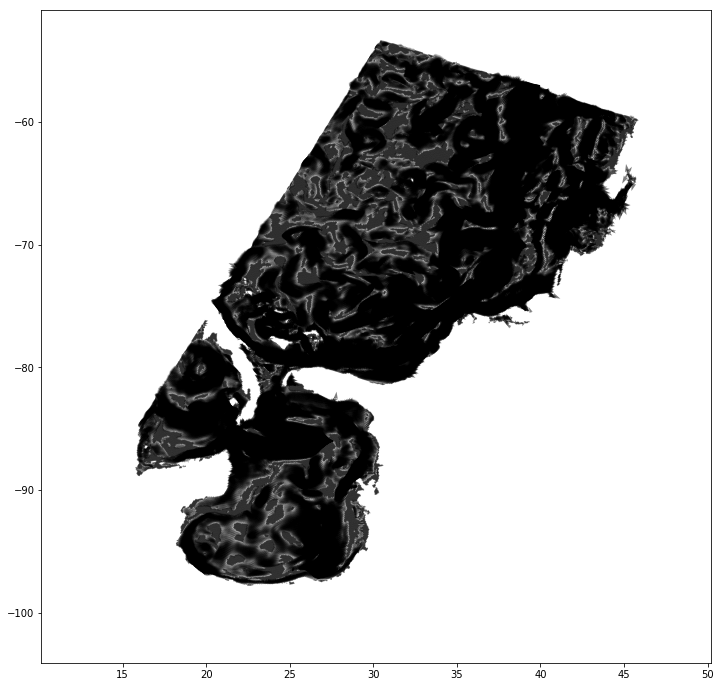

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

kw = dict(color='black', alpha=0.5, scale=50)
q = ax.quiver(lat_c, lon_c, u, v, **kw)

In [61]:
import mplleaflet

gj = mplleaflet.fig_to_geojson(fig=fig)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
import folium

feature_group0 = folium.FeatureGroup(name='quiver')

mapa = folium.Map(location=[41.5265, -70.6731], zoom_start=4.5,
                    tiles = 'Stamen Terrain')

for feature in gj['features']:
    if feature['geometry']['type'] == 'Point':
        lon, lat = feature['geometry']['coordinates']
        div = feature['properties']['html']

        icon_anchor = (feature['properties']['anchor_x'],
                       feature['properties']['anchor_y'])

        icon = folium.features.DivIcon(html=div,
                                       icon_anchor=icon_anchor)
        marker = folium.Marker([lat, lon], icon=icon)
        feature_group0.add_children(marker)
    else:
        msg = "Unexpected geometry {}".format
        raise ValueError(msg(feature['geometry']))

url = 'http://gmrt.marine-geo.org/cgi-bin/mapserv?map=/public/mgg/web/gmrt.marine-geo.org/htdocs/services/map/wms_merc.map'
wms = folium.features.WmsTileLayer(url,
                                   name='GMRT',
                                   format='image/png',
                                   layers='topo',
                                   transparent=True)
feature_group1 = folium.FeatureGroup(name='Topo')
feature_group1.add_child(wms)

In [ ]:
mapa.add_child(feature_group0)
mapa.add_child(feature_group1)
mapa.add_child(folium.map.LayerControl())
mapa

# Non-Folium Vector Attempt

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

In [11]:
tidx = -1       # just get the final frame, for now.
scale = .02 ## This variable can be played with to determine arrow size
isub = 3
url = 'http://geoport-dev.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd'

In [12]:
def shrink(a,b):
    """Return array shrunk to fit a specified shape by triming or averaging.
    
    a = shrink(array, shape)
    
    array is an numpy ndarray, and shape is a tuple (e.g., from
    array.shape). a is the input array shrunk such that its maximum
    dimensions are given by shape. If shape has more dimensions than
    array, the last dimensions of shape are fit.
    
    as, bs = shrink(a, b)
    
    If the second argument is also an array, both a and b are shrunk to
    the dimensions of each other. The input arrays must have the same
    number of dimensions, and the resulting arrays will have the same
    shape.
    Example
    -------
    
    >>> shrink(rand(10, 10), (5, 9, 18)).shape
    (9, 10)
    >>> map(shape, shrink(rand(10, 10, 10), rand(5, 9, 18)))        
    [(5, 9, 10), (5, 9, 10)]   
       
    """

    if isinstance(b, np.ndarray):
        if not len(a.shape) == len(b.shape):
            raise Exception(
                  'input arrays must have the same number of dimensions')
        a = shrink(a,b.shape)
        b = shrink(b,a.shape)
        return (a, b)

    if isinstance(b, int):
        b = (b,)

    if len(a.shape) == 1:                # 1D array is a special case
        dim = b[-1]
        while a.shape[0] > dim:          # only shrink a
            if (dim - a.shape[0]) >= 2:  # trim off edges evenly
                a = a[1:-1]
            else:                        # or average adjacent cells
                a = 0.5*(a[1:] + a[:-1])
    else:
        for dim_idx in range(-(len(a.shape)),0):
            dim = b[dim_idx]
            a = a.swapaxes(0,dim_idx)        # put working dim first
            while a.shape[0] > dim:          # only shrink a
                if (a.shape[0] - dim) >= 2:  # trim off edges evenly
                    a = a[1:-1,:]
                if (a.shape[0] - dim) == 1:  # or average adjacent cells
                    a = 0.5*(a[1:,:] + a[:-1,:])
            a = a.swapaxes(0,dim_idx)        # swap working dim back

    return a

In [13]:
def rot2d(x, y, ang):
    '''rotate vectors by geometric angle'''
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)
    return xr, yr

In [14]:
nc = netCDF4.Dataset(url)
mask = nc.variables['mask_rho'][:]
lon_rho = nc.variables['lon_rho'][:]
lat_rho = nc.variables['lat_rho'][:]
anglev = nc.variables['angle'][:]

u = nc.variables['u'][tidx, -1, :, :]
v = nc.variables['v'][tidx, -1, :, :]

u = shrink(u, mask[1:-1, 1:-1].shape)
v = shrink(v, mask[1:-1, 1:-1].shape)

u, v = rot2d(u, v, anglev[1:-1, 1:-1])

In [15]:
lon_c = lon_rho[1:-1, 1:-1]
lat_c = lat_rho[1:-1, 1:-1]

In [16]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [17]:
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

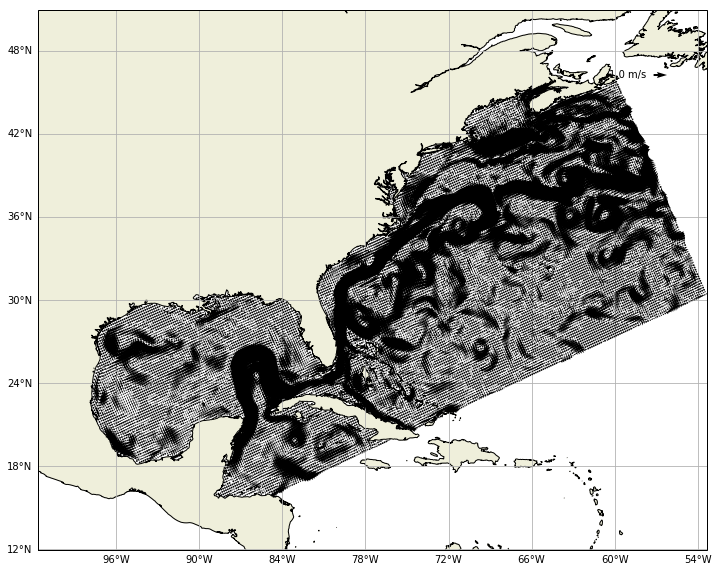

In [18]:
fig, ax = plt.subplots(figsize=(12,12),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([lon_c.min(), lon_c.max(), lat_c.min(), lat_c.max()])
ax.add_feature(LAND)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#kw = dict(scale=20, headwidth=2)
#n = 5
#q = ax.quiver(lon.points[::n, ::n], lat.points[::n, ::n],
#              u[::n, ::n], v[::n, ::n], color='black', **kw)
legend_vel=1.0
Q = ax.quiver( lon_c[::isub,::isub], lat_c[::isub,::isub], u[::isub,::isub], v[::isub,::isub], 
        scale=1.0/scale, pivot='middle', zorder=1e35, width=0.003)
legend_str='%3.1f m/s' % legend_vel
qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')